## Projet 6 : Classifiez automatiquement des biens de consommation

## Contexte

Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce.

Sur cette place de marché anglophone, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle, il devient nécessaire d'automatiser cette tâche d‘attribution de la catégorie.

Linda, Lead Data Scientist, vous demande donc d'étudier la faisabilité d'un moteur de classification des articles en différentes catégories, à partir du texte (en anglais) et de l’image.

## Librairies utilisées avec le langage Python:

In [151]:
# Importation des librairies
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps, ImageFilter
import cv2
import json
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.metrics import adjusted_rand_score
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
import os
import warnings
warnings.filterwarnings('ignore')


## Création du dataframe de classification des images :

Après l'importation, nous ne garderons que les variables intéressantes pour notre cas d'usage, c'est à dire la classification des descriptions des images des produits.

Gardons les variables :

*   product_name (identifiant unique produit),
*   description (données textes)
*   cat_niv_1 (classification cible),
*   cat_niv_1_num (classification cible numérique),
*   image (référence unique à l'image produit).


In [3]:
# Importation des données :
data = pd.read_csv('D:/tutorial-env/OCR/Projet6/data_txt_preprocessed.csv')
data.head()

,product_name,description,image,product_category_tree,cat_niv_1,cat_niv_2,_taille_description,cat_niv_1_num,description_preprocessed,description_token
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"[""Home Furnishing >> Curtains & Accessories >>...",Home Furnishing,Curtains & Accessories,1420,4,"['key', 'eleg', 'polyest', 'multicolor', 'abst...","['key', 'eleg', 'polyest', 'multicolor', 'abst..."
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care,Baby Bath & Skin,444,0,"['sathiya', 'cotton', 'bath', 'towel', 'bath',...","['sathiya', 'cotton', 'bath', 'towel', 'bath',..."
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care,Baby Bath & Skin,1258,0,"['key', 'eurospa', 'cotton', 'terri', 'face', ...","['key', 'eurospa', 'cotton', 'terri', 'face', ..."
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing,Bed Linen,858,4,"['key', 'santosh', 'royal', 'fashion', 'cotton...","['key', 'santosh', 'royal', 'fashion', 'cotton..."
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing,Bed Linen,1197,4,"['key', 'jaipur', 'print', 'cotton', 'floral',...","['key', 'jaipur', 'print', 'cotton', 'floral',..."


In [4]:
# Récupération des colonnes pertinentes :
data = data[['product_name',
             'description',
             'image',
             'cat_niv_1',
             'cat_niv_1_num']]

# Création du chemin des images :
path = 'D:/tutorial-env/OCR/Projet6/Flipkart/Images'
data['chemin_image'] = path + '/' + data['image']

data.head()

,product_name,description,image,cat_niv_1,cat_niv_1_num,chemin_image
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4,D:/tutorial-env/OCR/Projet6/Flipkart/Images/55...
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0,D:/tutorial-env/OCR/Projet6/Flipkart/Images/7b...
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0,D:/tutorial-env/OCR/Projet6/Flipkart/Images/64...
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4,D:/tutorial-env/OCR/Projet6/Flipkart/Images/d4...
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4,D:/tutorial-env/OCR/Projet6/Flipkart/Images/63...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_name   1050 non-null   object
 1   description    1050 non-null   object
 2   image          1050 non-null   object
 3   cat_niv_1      1050 non-null   object
 4   cat_niv_1_num  1050 non-null   int64 
 5   chemin_image   1050 non-null   object
dtypes: int64(1), object(5)
memory usage: 49.3+ KB


Comme vu dans le notebook pour la faisabilité de la classification textuelle, il n'y a ni doublon, ni valeur manquante dans notre dataframe. Aucun nettoyage n'est donc nécessaire.

Notre dataframe de classification des images contient donc 6 variables et 1050 produits.

## Analyse exploratoire univariée :


### Cible : product_category_tree

cf notebook pour la faisabilité de la classification textuelle

### Images

Regardonc la répartition des images en fonction de leur taille, largeur et hauteur :

In [5]:
# Répartition des tailles, largeurs et hauteurs des images :
tailles = []
largeurs = []
hauteurs = []

for chemin in data['chemin_image']:
    image = Image.open(chemin)

    largeur, hauteur = image.size
    taille = largeur * hauteur

    tailles.append(taille)
    largeurs.append(largeur)
    hauteurs.append(hauteur)

data['taille'] = tailles
data['largeur'] = largeurs
data['hauteur'] = hauteurs

data

,product_name,description,image,cat_niv_1,cat_niv_1_num,chemin_image,taille,largeur,hauteur
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4,D:/tutorial-env/OCR/Projet6/Flipkart/Images/55...,12960000,3600,3600
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0,D:/tutorial-env/OCR/Projet6/Flipkart/Images/7b...,3087684,2388,1293
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0,D:/tutorial-env/OCR/Projet6/Flipkart/Images/64...,715878,982,729
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4,D:/tutorial-env/OCR/Projet6/Flipkart/Images/d4...,914100,1100,831
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4,D:/tutorial-env/OCR/Projet6/Flipkart/Images/63...,5574960,2670,2088
...,...,...,...,...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,Oren Empower Extra Large Self Adhesive Sticker...,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0,D:/tutorial-env/OCR/Projet6/Flipkart/Images/95...,1030700,1100,937
1046,Wallmantra Large Vinyl Sticker Sticker,Wallmantra Large Vinyl Sticker Sticker (Pack o...,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,0,D:/tutorial-env/OCR/Projet6/Flipkart/Images/fd...,1080000,900,1200
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,0,D:/tutorial-env/OCR/Projet6/Flipkart/Images/59...,1112100,1100,1011
1048,Wallmantra Medium Vinyl Sticker Sticker,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,0,D:/tutorial-env/OCR/Projet6/Flipkart/Images/c3...,1080000,900,1200


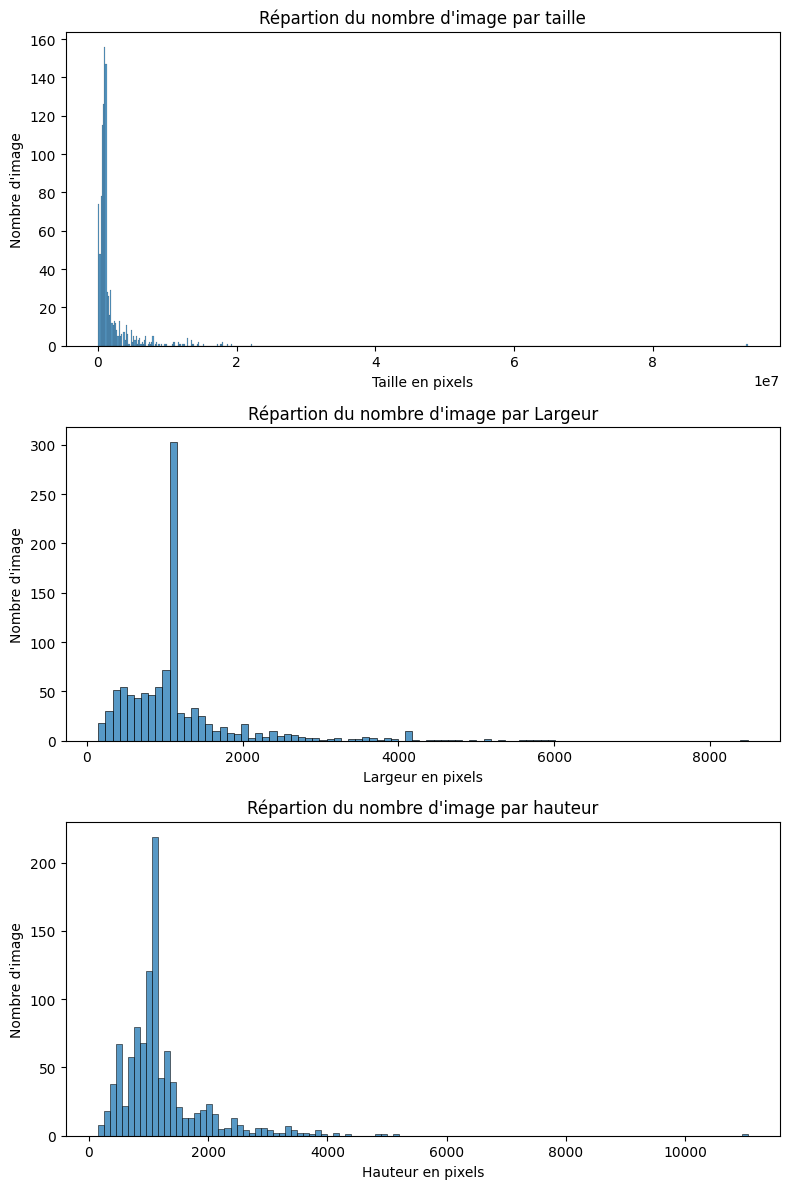

In [ ]:
plt.figure(figsize=(8,12))

plt.subplot(3, 1, 1)
sns.histplot(
    data=data['taille'],
    )
plt.xlabel('Taille en pixels')
plt.ylabel("Nombre d'image")
plt.title("Répartion du nombre d'image par taille")

plt.subplot(3, 1, 2)
sns.histplot(
    data=data['largeur'],
    )
plt.xlabel('Largeur en pixels')
plt.ylabel("Nombre d'image")
plt.title("Répartion du nombre d'image par Largeur")

plt.subplot(3, 1, 3)
sns.histplot(
    data=data['hauteur'],
    )
plt.xlabel('Hauteur en pixels')
plt.ylabel("Nombre d'image")
plt.title("Répartion du nombre d'image par hauteur")

plt.tight_layout()
plt.show()

Les tailles, largeurs et hauteurs sont très diverses.

Regardons maintenant leur format :

In [ ]:
# format des images :
formats = []

for chemin in data['chemin_image']:
    image = Image.open(chemin)

    format = image.mode

    formats.append(format)

Counter(formats)

Counter({'RGB': 1050})

Toutes les images sont au format RGB. Chaque pixel a donc 3 valeurs comprises entre 0 et 255 pour coder les 3 couleurs Red, Green et Blue.

## Analyse exploratoire multivariée :

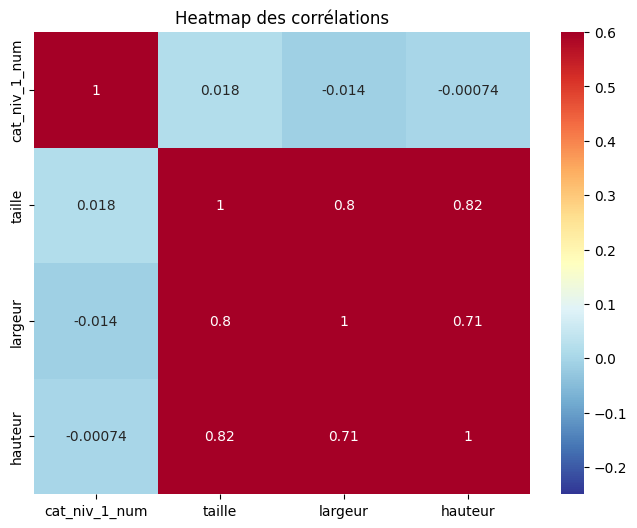

In [ ]:
plt.figure(figsize = (8, 6))

# Sélection des colonnes numériques
data_corr = data.select_dtypes(include=['int64', 'int32'])

# Heatmap des correlations
sns.heatmap(data_corr.corr(),
            cmap = plt.cm.RdYlBu_r,
            vmin = -0.25,
            vmax = 0.6,
            annot = True)
plt.title('Heatmap des corrélations')
plt.show()

On retrouve de façon logique une forte corrélation entre la taille, la largeur et la hauteur mais aucun de ces trois paramètres n'est corrélé avec la catégorie.

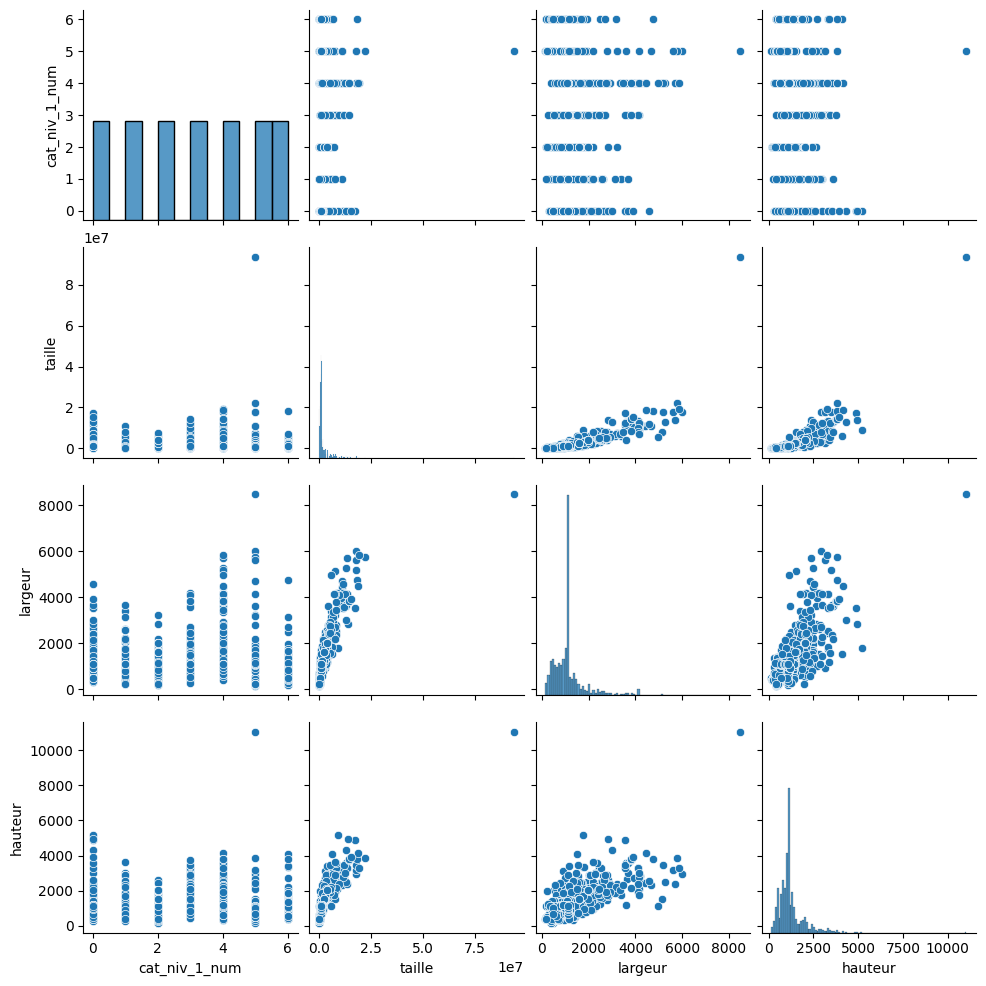

In [ ]:
sns.pairplot(data_corr)
plt.show()

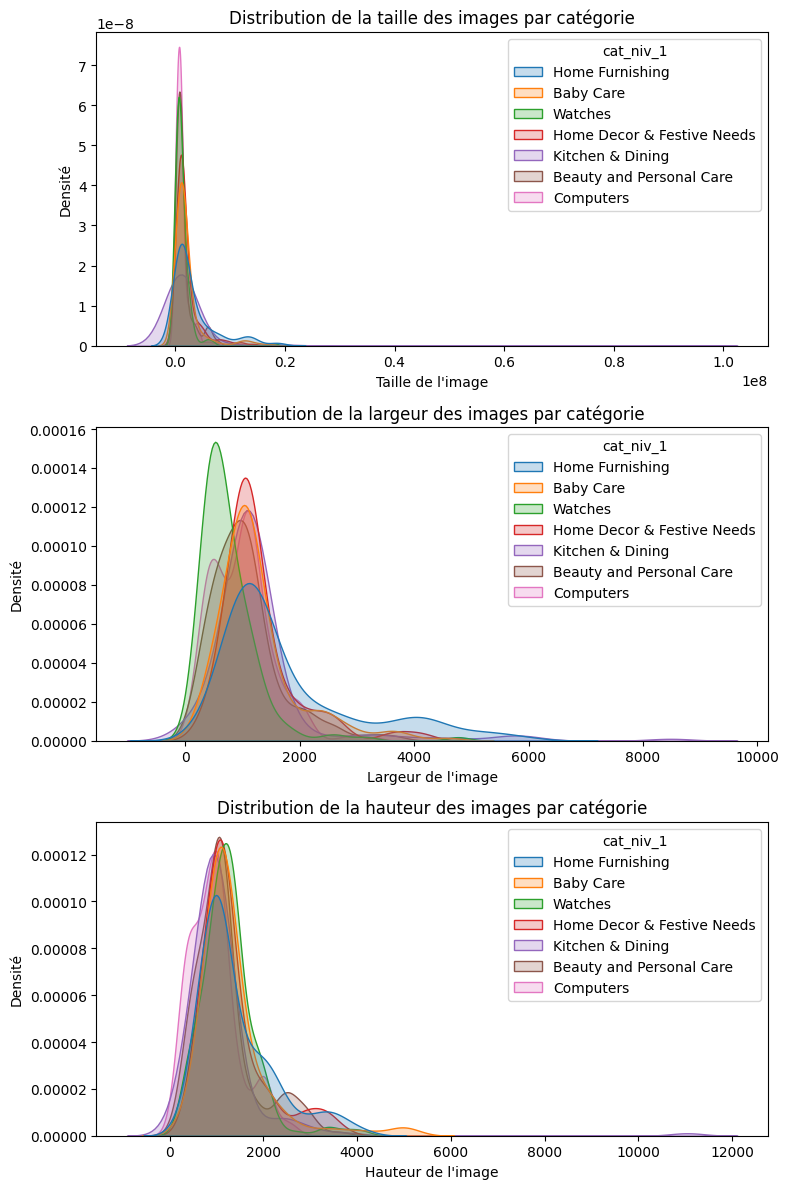

In [ ]:
plt.figure(figsize=(8,12))

plt.subplot(3, 1, 1)
sns.kdeplot( x = 'taille', hue = 'cat_niv_1', data = data, fill = True)
plt.title('Distribution de la taille des images par catégorie')
plt.xlabel('Taille de l\'image')
plt.ylabel('Densité')

plt.subplot(3, 1, 2)
sns.kdeplot( x = 'largeur', hue = 'cat_niv_1', data = data, fill = True)
plt.title('Distribution de la largeur des images par catégorie')
plt.xlabel('Largeur de l\'image')
plt.ylabel('Densité')

plt.subplot(3, 1, 3)
sns.kdeplot( x = 'hauteur', hue = 'cat_niv_1', data = data, fill = True)
plt.title('Distribution de la hauteur des images par catégorie')
plt.xlabel('Hauteur de l\'image')
plt.ylabel('Densité')

plt.tight_layout()
plt.show()

Les distributions des tailles, largeurs et hauteurs sont assez similaires entre les différentes catégories.


## Pré-traitement des images :

Plusieurs opérations sont nécessaires :    

*   Redimensionnement des images en 244x244 pour le CNN de modèle VGG16
*   Transformation en niveau de gris pour le modèle SIFT
*   Suppression du bruit
*   Egalisation des histogrammes





In [6]:
# Fonction permettant de visualiser le pourcentage de valeurs manquantes par variables

def preprocess_image(data : pd.DataFrame) -> pd.DataFrame:

    '''Prend un dataframe de chemin d'images en entrée sur lesquelles le pré-traitement sera appliqué
    (redimensionnement, niveau de gris, suppression du bruit et égalisation des histogrammes)
    Args:
        data (pd.DataFrame): Dataframe avec les chemins des images sur lesquelles il faut réaliser le pré-traitement
    Sortie:
        pd.DataFrame: Dataframe avec les chemins des images pré-traitées
    '''
    chemin_sauvegarde_list = []

    for chemin_image in data['chemin_image'] :

      # Chargement de l'image :
      image = Image.open(chemin_image)

      # Redimensionnement de la taille à 224x224 :
      image = image.resize((224, 224), Image.LANCZOS)

      # Transformation en niveaux de gris :
      image = image.convert('L')

      # Suppression du bruit avec un filtre médian :
      image = image.filter(ImageFilter.MedianFilter(size=3))

      # Égalisation de l'histogramme :
      image = ImageOps.equalize(image)

      # Sauvegarde des images traitées :
      chemin_sauvegarde = chemin_image.replace("Images", "Images traitées")
      image.save(chemin_sauvegarde)
      chemin_sauvegarde_list.append(chemin_sauvegarde)

    data['chemin_image_traitee'] = chemin_sauvegarde_list

    return data


In [7]:
# Pré-traitement des images
data = preprocess_image(data)
data

,product_name,description,image,cat_niv_1,cat_niv_1_num,chemin_image,taille,largeur,hauteur,chemin_image_traitee
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4,D:/tutorial-env/OCR/Projet6/Flipkart/Images/55...,12960000,3600,3600,D:/tutorial-env/OCR/Projet6/Flipkart/Images tr...
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0,D:/tutorial-env/OCR/Projet6/Flipkart/Images/7b...,3087684,2388,1293,D:/tutorial-env/OCR/Projet6/Flipkart/Images tr...
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0,D:/tutorial-env/OCR/Projet6/Flipkart/Images/64...,715878,982,729,D:/tutorial-env/OCR/Projet6/Flipkart/Images tr...
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4,D:/tutorial-env/OCR/Projet6/Flipkart/Images/d4...,914100,1100,831,D:/tutorial-env/OCR/Projet6/Flipkart/Images tr...
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4,D:/tutorial-env/OCR/Projet6/Flipkart/Images/63...,5574960,2670,2088,D:/tutorial-env/OCR/Projet6/Flipkart/Images tr...
...,...,...,...,...,...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,Oren Empower Extra Large Self Adhesive Sticker...,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0,D:/tutorial-env/OCR/Projet6/Flipkart/Images/95...,1030700,1100,937,D:/tutorial-env/OCR/Projet6/Flipkart/Images tr...
1046,Wallmantra Large Vinyl Sticker Sticker,Wallmantra Large Vinyl Sticker Sticker (Pack o...,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,0,D:/tutorial-env/OCR/Projet6/Flipkart/Images/fd...,1080000,900,1200,D:/tutorial-env/OCR/Projet6/Flipkart/Images tr...
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,0,D:/tutorial-env/OCR/Projet6/Flipkart/Images/59...,1112100,1100,1011,D:/tutorial-env/OCR/Projet6/Flipkart/Images tr...
1048,Wallmantra Medium Vinyl Sticker Sticker,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,0,D:/tutorial-env/OCR/Projet6/Flipkart/Images/c3...,1080000,900,1200,D:/tutorial-env/OCR/Projet6/Flipkart/Images tr...


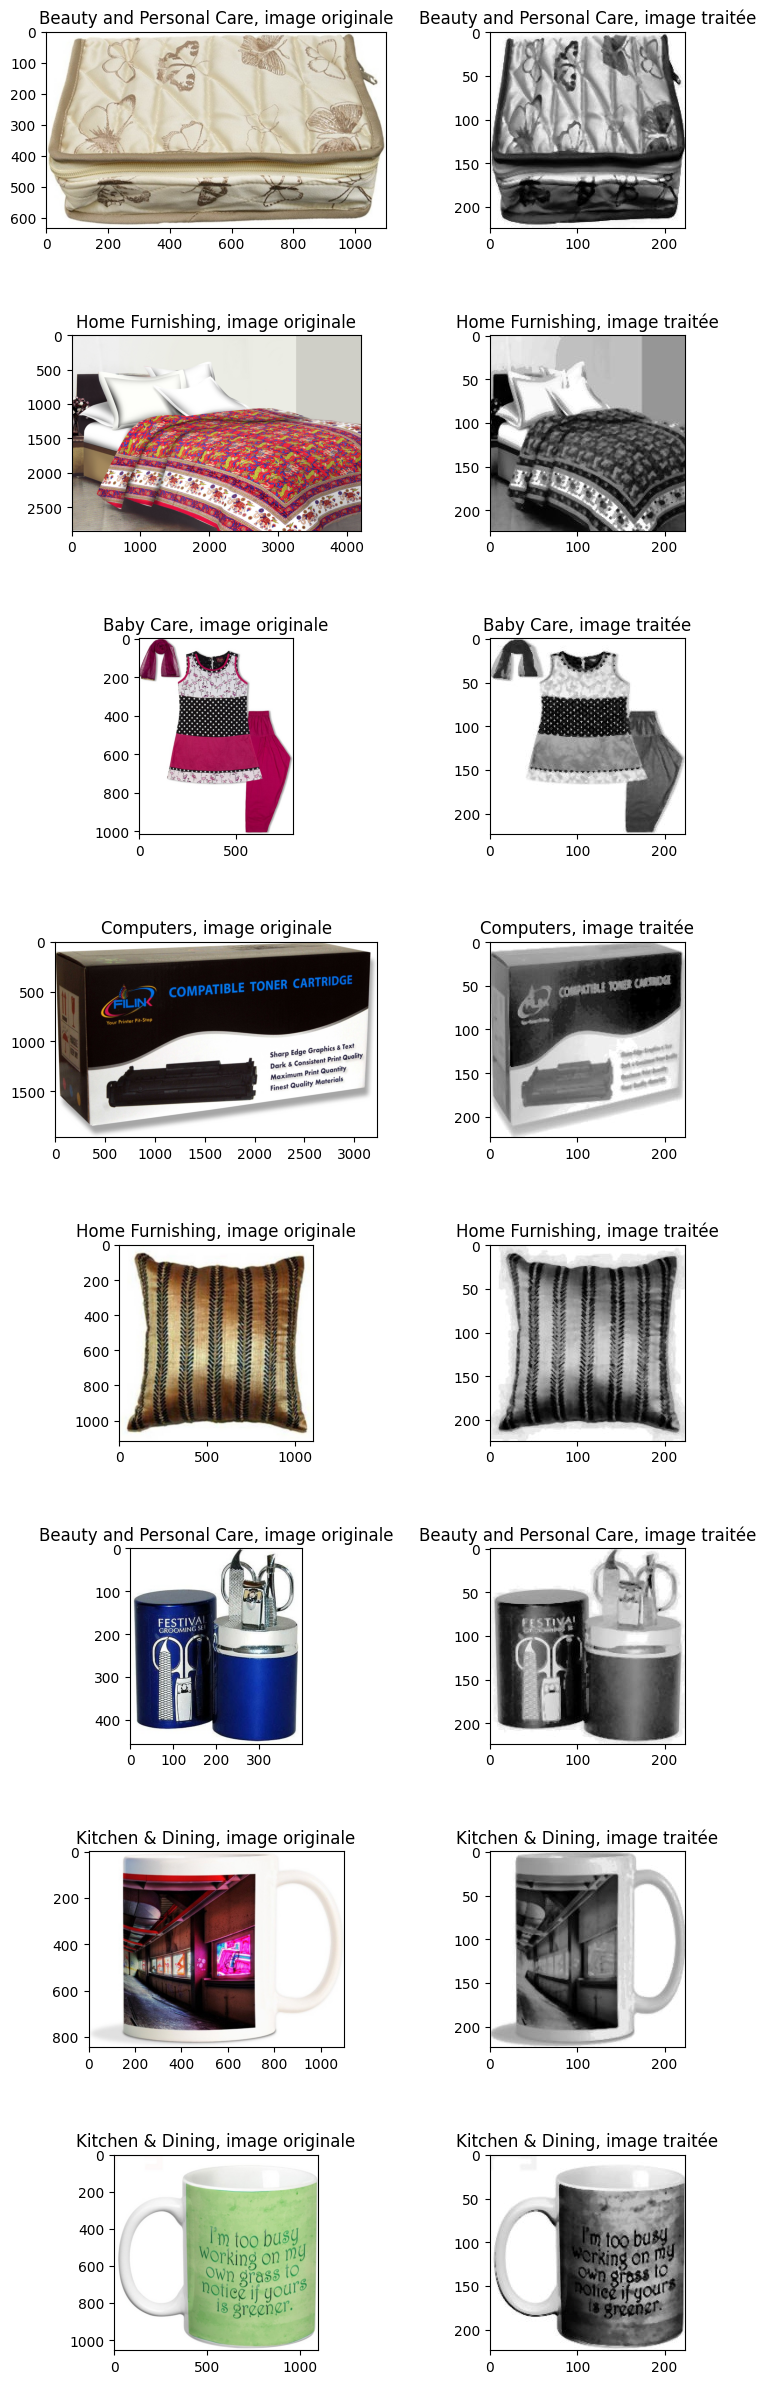

In [ ]:
# Visualisation des images pré-traitées

plt.figure(figsize=(15, 30))
pos=0
for i in range(100,140,5):

    image = Image.open(data.loc[i, 'chemin_image'])
    image_traitee = Image.open(data.loc[i,'chemin_image_traitee'])
    categ = data.loc[i, 'cat_niv_1']
    pos=pos+1
    plt.subplot(10, 1, pos)
    plt.imshow(image, cmap='gray')
    plt.title(f"{categ}, image originale")

    plt.subplot(10, 2, 2*pos)
    plt.imshow(image_traitee, cmap='gray')
    plt.title(f"{categ}, image traitée")
plt.tight_layout()
plt.show()

## Détection de features :

### Méthode SIFT:

La méthode SIFT (Scale Invariant Feature Transform) permet la détection et la description de points d'intérêts dans les images.

Elle est invariante aux transformations de rotation et d'échelle.

Pour la détection, l'image est floutée plusieurs fois par convolution gaussienne à différentes échelles et la différence entre les images floutées est calculée. C'est en trouvant les maxima locaux que les point clés sont détectés.

Ensuite, un nettoyage est effectué dans ces points clés en enlevant les points correspondant à des bords par exemple. SIFT utilise des tests de stabilité et de contraste pour cela.

Pour chaque point restant, SIFT calcule l'orientation dominante en se basant sur les gradients de l'intensité des pixels dans la région autour du point (d'où l'invariance à la rotation).

Chaque point clé est représenté par un vecteur qui code la région du point : le descripteur. Ce vecteur est calculé en divisant la région autour du point clé en plusieurs sous-région et en enregistrant les gradients d'orientation dans chaque sous-région. Cela donne un vecteur de 128 dimensions unique pour chaque point clé.

In [19]:
#Instanciation de SIFT :
sift = cv2.SIFT_create()

sift_result = {}
descripteurs_list_all = []
idx = 0

for chemin in data['chemin_image_traitee']:
  descripteurs_list = []
  image = np.array(Image.open(chemin))

  # Détecter les points clés et calculer les descripteurs
  key_point, descripteurs = sift.detectAndCompute(image, None)
  sift_result[chemin] = {
      'point_cle' : key_point,
      'descripteur' : descripteurs
      }

  # Conversion en array et sauvegarde des descripteurs par image
  descripteurs_list.append(descripteurs)
  data.loc[idx, 'descripteur'] = descripteurs_list

  # Sauvegarde des descripteurs de toutes les images
  descripteurs_list_all.extend(descripteurs)
  idx = idx + 1

print(f"Nombre de features sur l'ensemble des image du dataset : {len(descripteurs_list_all)}")

Nombre de features sur l'ensemble des image du dataset : 425738


Maintenant que nous avons extrait les features, nous devons créer le dictionnaire des visual words en utilisant un KMeans pour faire le clustering des features.

Pour avoir la valeur k du nombre de clusters :    


*   k min = nb de catégorie * 10
*   k max = racine carrée du nombre de features

Ici, k doit se situer entre 70 et 653.

Avec ces informations, cherchons à optimiser k :



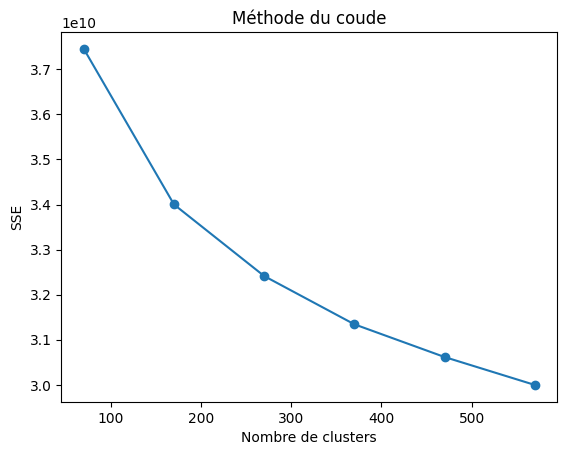

In [ ]:
# Optimisation du nombre de clusters avec la méthode du coude :

SSE = []
for i in range(70,670,100):
    kmeans_sse = MiniBatchKMeans(
        n_clusters = i,
        init = 'k-means++',
        n_init = 10,
        max_iter = 300,
        random_state = 42
    )
    kmeans_sse.fit(descripteurs_list_all)
    SSE.append(kmeans_sse.inertia_)

# Visualisation de la courbe de la méthode du coude
plt.plot(range(70,670,100), SSE, marker = 'o')
plt.xlabel('Nombre de clusters')
plt.ylabel('SSE')
plt.title('Méthode du coude')
plt.show()

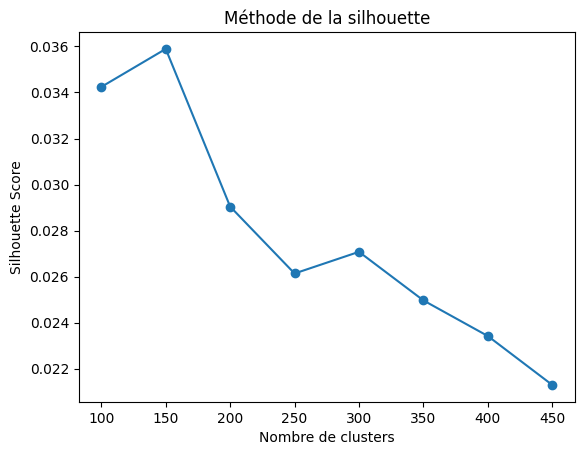

In [ ]:
labels = data['cat_niv_1'].unique()
sil = []
for i in range(100,500,50):
    kmeans_sil = MiniBatchKMeans(
        n_clusters = i,
        init = 'k-means++',
        n_init = 10,
        max_iter = 300,
        random_state = 42
    )
    kmeans_sil.fit(descripteurs_list_all)
    labels = kmeans_sil.labels_
    sil.append(silhouette_score(descripteurs_list_all, labels))

# Visualisation de la courbe de la méthode de la silhouette
plt.plot(range(100,500,50), sil, marker = 'o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.title('Méthode de la silhouette')
plt.show()

Choisissons 150 clusters, donc un dictionnaire de 150 visual words.

In [9]:
# Création des visual words
kmeans = MiniBatchKMeans(n_clusters=150,
                         init = 'k-means++',
                         n_init = 10,
                         max_iter = 300,
                         random_state = 42
                         )
kmeans.fit(descripteurs_list_all)
visual_words_centers = kmeans.cluster_centers_



Passons au traitement de chaque image traitée :
*   prédiction des clusters/visual words de chaque descripteur
*   création d'un histogramme qui compte le nombre de descripteur pour chaque cluster/visual words


In [77]:
kmeans.cluster_centers_.dtype

dtype('float64')

In [106]:
def build_histogram(kmeans,  descript) -> pd.DataFrame:

    '''Création d'un histogramme à partir des descripteurs d'une image
    Args:
        kmeans : instance de KMeans du dictionnaire de visual visual_words_centers
        descript (list): liste des descripteurs de l'image
    Sortie:
        pd.DataFrame: Dataframe avec les chemins des images pré-traitées
    '''
    descript = np.asarray(descript, dtype = np.float64)

    # prédiction des clusters pour chaque descripteur
    result = kmeans.predict(descript)

    # Initialisation et complétion de l'histogramme
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_descript = len(descript)

    for i in result:
      hist[i] += 1.0/nb_descript #Normalisation en divisant par le nombre de descripteurs

    return hist

In [128]:
hist_vectors = []
data['histogramme'] = None
# idx = 0
for idx,desc in enumerate(data['descripteur']) :
    # suppression de l'encapsulation des descripteurs
    desc = np.squeeze(np.asarray(desc,dtype = np.float64),axis = 0)

    # Création de l'histogramme de l'image et stockage dans le dataframe
    hist = build_histogram(kmeans, desc)
    data.at[idx, 'histogramme'] = [hist.tolist()]
    hist_vectors.append(hist)

im_features = np.asarray(hist_vectors)

In [126]:
data

,product_name,description,image,cat_niv_1,cat_niv_1_num,chemin_image,taille,largeur,hauteur,chemin_image_traitee,descripteur,histogramme
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4,D:/tutorial-env/OCR/Projet6/Flipkart/Images/55...,12960000,3600,3600,D:/tutorial-env/OCR/Projet6/Flipkart/Images tr...,"[[[0.0, 0.0, 9.0, 24.0, 6.0, 3.0, 3.0, 3.0, 0....","[[0.005813953488372093, 0.0, 0.0, 0.0019379844..."
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0,D:/tutorial-env/OCR/Projet6/Flipkart/Images/7b...,3087684,2388,1293,D:/tutorial-env/OCR/Projet6/Flipkart/Images tr...,"[[[0.0, 0.0, 0.0, 8.0, 91.0, 69.0, 5.0, 1.0, 1...","[[0.0019723865877712033, 0.0039447731755424065..."
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0,D:/tutorial-env/OCR/Projet6/Flipkart/Images/64...,715878,982,729,D:/tutorial-env/OCR/Projet6/Flipkart/Images tr...,"[[[0.0, 66.0, 158.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0015600624024961, 0.0, 0.0, 0.0, 0.0187207..."
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4,D:/tutorial-env/OCR/Projet6/Flipkart/Images/d4...,914100,1100,831,D:/tutorial-env/OCR/Projet6/Flipkart/Images tr...,"[[[31.0, 24.0, 43.0, 42.0, 14.0, 5.0, 2.0, 11....","[[0.003690036900369004, 0.00984009840098401, 0..."
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4,D:/tutorial-env/OCR/Projet6/Flipkart/Images/63...,5574960,2670,2088,D:/tutorial-env/OCR/Projet6/Flipkart/Images tr...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0...","[[0.001455604075691412, 0.017467248908296946, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,Oren Empower Extra Large Self Adhesive Sticker...,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0,D:/tutorial-env/OCR/Projet6/Flipkart/Images/95...,1030700,1100,937,D:/tutorial-env/OCR/Projet6/Flipkart/Images tr...,"[[[187.0, 5.0, 0.0, 1.0, 13.0, 11.0, 33.0, 62....","[[0.0025974025974025974, 0.0, 0.00519480519480..."
1046,Wallmantra Large Vinyl Sticker Sticker,Wallmantra Large Vinyl Sticker Sticker (Pack o...,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,0,D:/tutorial-env/OCR/Projet6/Flipkart/Images/fd...,1080000,900,1200,D:/tutorial-env/OCR/Projet6/Flipkart/Images tr...,"[[[0.0, 144.0, 135.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[[0.013761467889908258, 0.0045871559633027525,..."
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,0,D:/tutorial-env/OCR/Projet6/Flipkart/Images/59...,1112100,1100,1011,D:/tutorial-env/OCR/Projet6/Flipkart/Images tr...,"[[[27.0, 3.0, 4.0, 2.0, 1.0, 0.0, 0.0, 22.0, 1...","[[0.00202020202020202, 0.00202020202020202, 0...."
1048,Wallmantra Medium Vinyl Sticker Sticker,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,0,D:/tutorial-env/OCR/Projet6/Flipkart/Images/c3...,1080000,900,1200,D:/tutorial-env/OCR/Projet6/Flipkart/Images tr...,"[[[133.0, 39.0, 18.0, 18.0, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.008849557522123894, 0.0, 0.00884..."


####  *PCA*

*réduction de dimensionnalité + atténuation du bruit*

In [132]:
# Réduction de dimension par PCA
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)


Dimensions dataset avant réduction PCA :  (1050, 150)
Dimensions dataset après réduction PCA :  (1050, 135)


####  *T-SNE*

*meilleure séparation des clusters car il permet de préserver les distances entre les points proches -> meilleure performance du K-Means car points plus distincts + amélioration de la visualisation*

In [135]:
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, random_state=42)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class_reelle"] = data["cat_niv_1_num"]
df_tsne

,tsne1,tsne2,class_reelle
0,-2.557267,-7.218550,4
1,-2.146738,-1.201995,0
2,8.026161,19.792845,0
3,-22.128038,3.610557,4
4,-21.891783,10.697539,4
...,...,...,...
1045,-6.990151,23.195692,0
1046,3.349599,11.655527,0
1047,-17.251688,12.754944,0
1048,25.708237,-1.419181,0


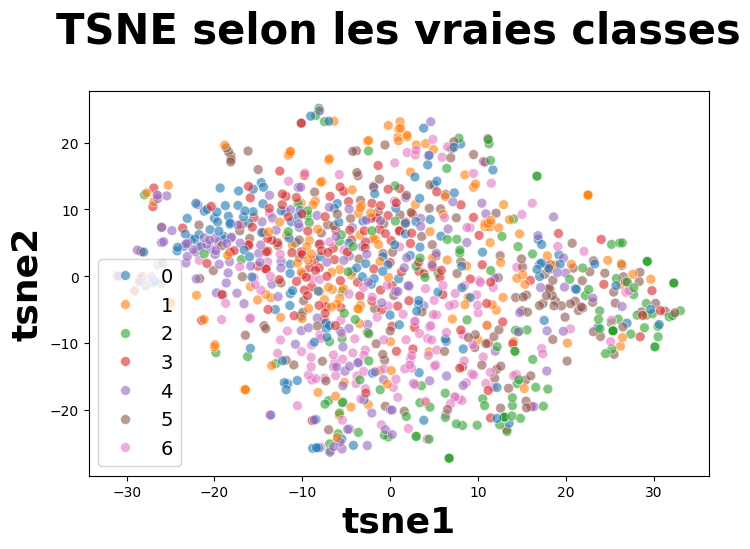

In [137]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class_reelle", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()


####  *Clustering KMeans*

In [138]:
# Clustering par KMeans avec 7 clusters correspondants aux 7 catégories de niveau 1
kmeans = KMeans(
    init = 'k-means++',
    n_clusters = 7,
    n_init = 10,
    max_iter = 300,
    random_state = 42
)
kmeans.fit(X_tsne)

KMeans(n_clusters=7, n_init=10, random_state=42)

In [139]:
df_tsne["class_predite"] = kmeans.labels_

In [141]:
df_tsne.groupby('class_predite').size()

class_predite
0    122
1    144
2    152
3    163
4    162
5    181
6    126
dtype: int64

Nous avons une répartition très équilibrée.

####  *Visualisation des clusters*

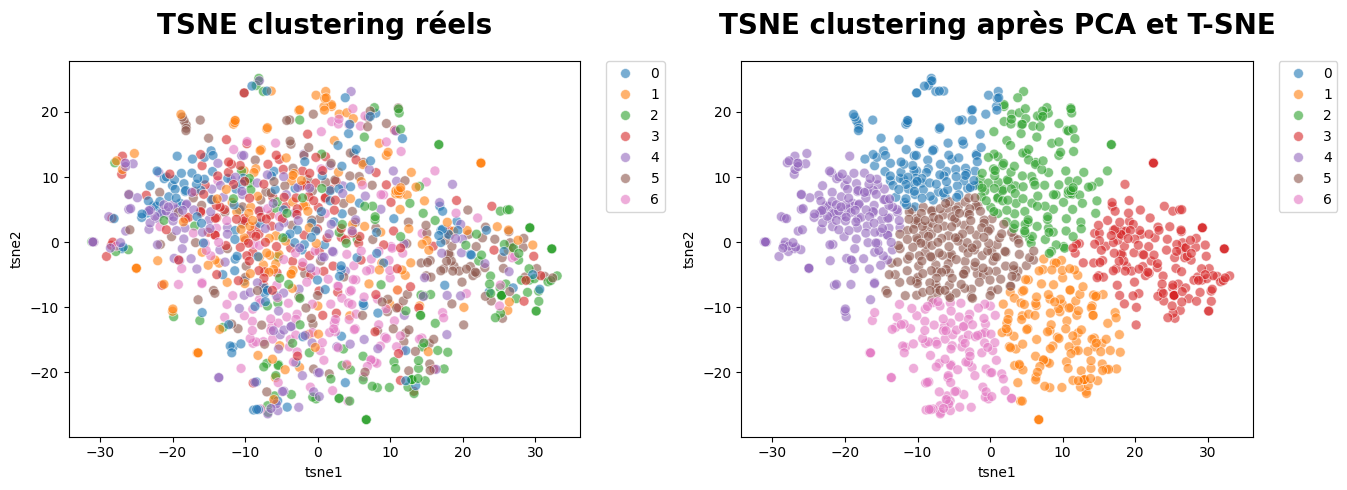

In [142]:
# Visualiser les deux clusters avec les mêmes points TSNE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Premier sous-graphique : clusters initiaux
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class_reelle",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief",
    ax=ax1
)
ax1.set_title('TSNE clustering réels', fontsize=20, pad=20, fontweight='bold')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Deuxième sous-graphique : clustering après PCA et T-SNE
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class_predite",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief",
    ax=ax2
)
ax2.set_title('TSNE clustering après PCA et T-SNE', fontsize=20, pad=20, fontweight='bold')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.tight_layout(rect=[0,0,0.85,1])
plt.show()

Nous avons une répartition plutôt équilibrée de nos clusters proche de la classification initiale du jeu de données (150 pour chaque catégorie).

In [145]:
# Calcul de l'ARI entre les paires de labels
ari = adjusted_rand_score(df_tsne["class_reelle"], df_tsne["class_predite"])
print(f"Le score ARI est de :", ari)

Le score ARI est de : 0.045685690085572585


Avec la méthode SIFT, le clustering est plutôt équilibré comme le clustering initial mais le score ARI est très bas, peu d'images sont correctement classées.

###  Méthode CNN (Convolution Neural Network) Transfer Learning

Le modèle de CNN VGG16 sera celui utilisé pour cette tâche de classification d'images.

VGG-16 est constitué de plusieurs couches, dont 13 couches de convolution et 3 fully-connected. Il doit donc apprendre les poids de 16 couches.

Il prend en entrée une image en couleurs de taille 224×224 pixels.

Voici l'architecture du VGG16 :     

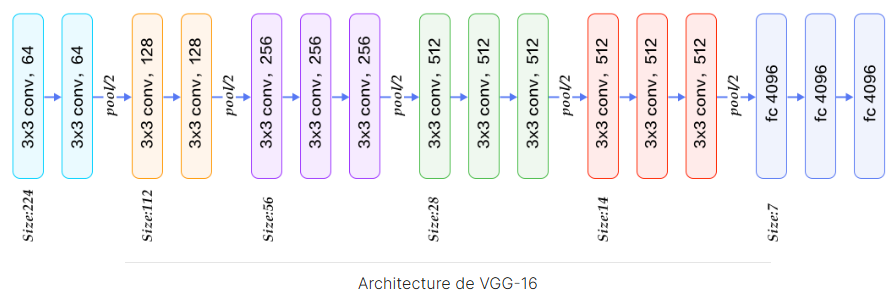

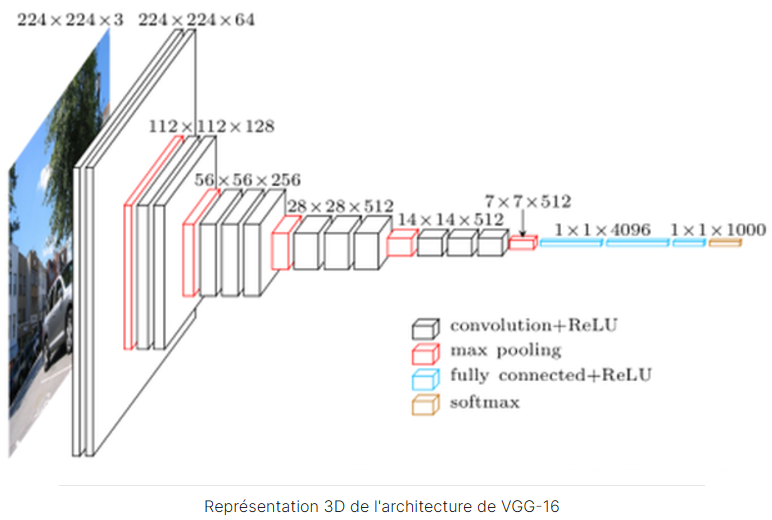

Chaque couche de convolution utilise des filtres en couleurs de taille 3×3 pixels, déplacés avec un pas de 1 pixel. Le zero-padding vaut 1 pixel afin que les volumes en entrée aient les mêmes dimensions en sortie. Le nombre de filtres varie selon le "bloc" dans lequel la couche se trouve. De plus, un paramètre de biais est introduit dans le produit de convolution pour chaque filtre.

Après chaque convolution, une couche ReLU (Rectified Linear Unit) est utilisé comme fonction d'activation.

Après chaque groupe de convolutions, une couche de pooling de 2x2 permet de réduire les dimensions et son pas de 2 pixels permet que les cellules ne se chevauchent pas.

Les deux premières couches fully-connected calculent chacune un vecteur de taille 4096, et sont chacune suivies d'une couche ReLU.

Le modèle est préentrainé sur le dataset ImageNet.

In [ ]:
# Instanciantion d'un réseau de neurone vide
# my_VGG16 = Sequential()

# Les couches s'ajoutent soit en tant que paramètres d'entrée du constructeur  Sequential() , soit une par une avec la méthode mon_reseau_VGG.add() .
# Les couches de convolution, pooling et fully-connected correspondent à des instances des classes respectives Conv2D, MaxPooling2D et Dense du module  keras.layers .
# Une couche ReLU peut être créée soit en instanciant la classe Activation, soit en ajoutant un argument au constructeur de la couche qui la précède.

# Pour construire une couche de convolution, nous devons préciser le nombre de filtres utilisés, leur taille, le pas et le zero-padding.
# Ils correspondent respectivement aux arguments  filters ,  kernel_size ,  strides  et  padding (choix : 'same' ou 'valid')  du constructeur de la classe  Conv2D .
# La couche de convolution réduit la taille du volume en entrée avec l'option 'valid', mais la conserve avec 'same'. Pour VGG-16, on utilisera donc toujours l'option 'same'.

# S'il s'agit de la toute première couche de convolution, il faut préciser dans l'argument input_shape  les dimensions des images en entrée du réseau. Pour VGG-16, input_shape = (224, 224, 3) .
# Enfin, pour indiquer la présence d'une couche ReLU juste après la couche de convolution, on ajoute l'argument activation = 'relu' .
# Une couche de pooling est définie par la taille des cellules de pooling et le pas avec lequel on les déplace.
# Ces paramètres sont précisés dans les arguments respectifs pool_size  et strides  du constructeur de la classe MaxPooling2D .

# Il ne reste plus qu'à ajouter les couches fully-connected, en créant des objets de la classe  Dense.
# Ce type de couche reçoit en entrée un vecteur 1D. Il faut donc convertir les matrices 3D renvoyées par la dernière couche de pooling. Pour cela, on instancie la classe Flatten juste avant la première couche fully-connected.
# L'argument  units  du constructeur de  Dense  permet de préciser la taille du vecteur en sortie.
# De plus, si une correction ReLU ou softmax est effectuée juste après la couche fully-connected, on l'indique dans le paramètre  activation
# Ainsi, les trois dernières couches fully-connected et leur fonction d'activation (ReLU pour les deux premières, softmax pour la dernière)

In [153]:
# Instanciantion d'un réseau de neurone VGG16
model = VGG16()

# Suppression des deux dernières couches fully-connected de classification
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [154]:
images_features = []

for image_file in data["chemin_image"] :
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

(1050, 4096)

####  *PCA*

*réduction de dimensionnalité + atténuation du bruit*

In [155]:
# Réduction de dimension par PCA
print("Dimensions dataset avant réduction PCA : ", images_features.shape)
pca = PCA(n_components=0.99)
images_features_pca= pca.fit_transform(images_features)
print("Dimensions dataset après réduction PCA : ", images_features_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 803)


En prenant les 803 premiers composant de la PCA, on explique 99% de la matrice creuse.

####  *T-SNE*

*meilleure séparation des clusters car il permet de préserver les distances entre les points proches -> meilleure performance du K-Means car points plus distincts + amélioration de la visualisation*

In [158]:
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, random_state=42)
X_tsne = tsne.fit_transform(images_features_pca)

df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class_reelle"] = data["cat_niv_1_num"]
df_tsne

,tsne1,tsne2,class_reelle
0,-22.555080,24.323177,4
1,-1.859800,21.219131,0
2,3.053312,21.953115,0
3,-14.520279,29.579660,4
4,-23.942602,31.056112,4
...,...,...,...
1045,-21.468410,24.600985,0
1046,-7.051853,6.870439,0
1047,-8.853291,7.166760,0
1048,-7.331587,7.926476,0


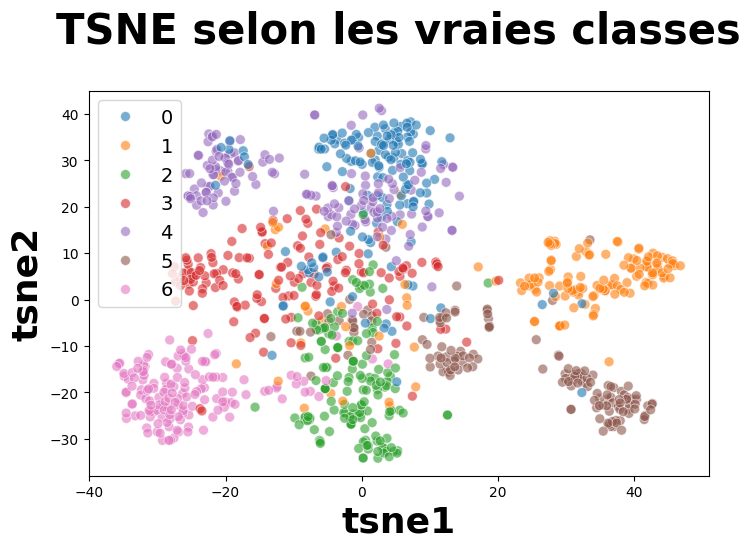

In [159]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class_reelle", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()

####  *Clustering KMeans*

In [160]:
# Clustering par KMeans avec 7 clusters correspondants aux 7 catégories de niveau 1
kmeans = KMeans(
    init = 'k-means++',
    n_clusters = 7,
    n_init = 10,
    max_iter = 300,
    random_state = 42
)
kmeans.fit(X_tsne)

KMeans(n_clusters=7, n_init=10, random_state=42)

In [161]:
df_tsne["class_predite"] = kmeans.labels_

In [162]:
df_tsne.groupby('class_predite').size()

class_predite
0    132
1    146
2    199
3    189
4     80
5    136
6    168
dtype: int64

Nous avons une répartition équilibrée mais moins qu'avec la méthode SIFT.

####  *Visualisation des clusters*


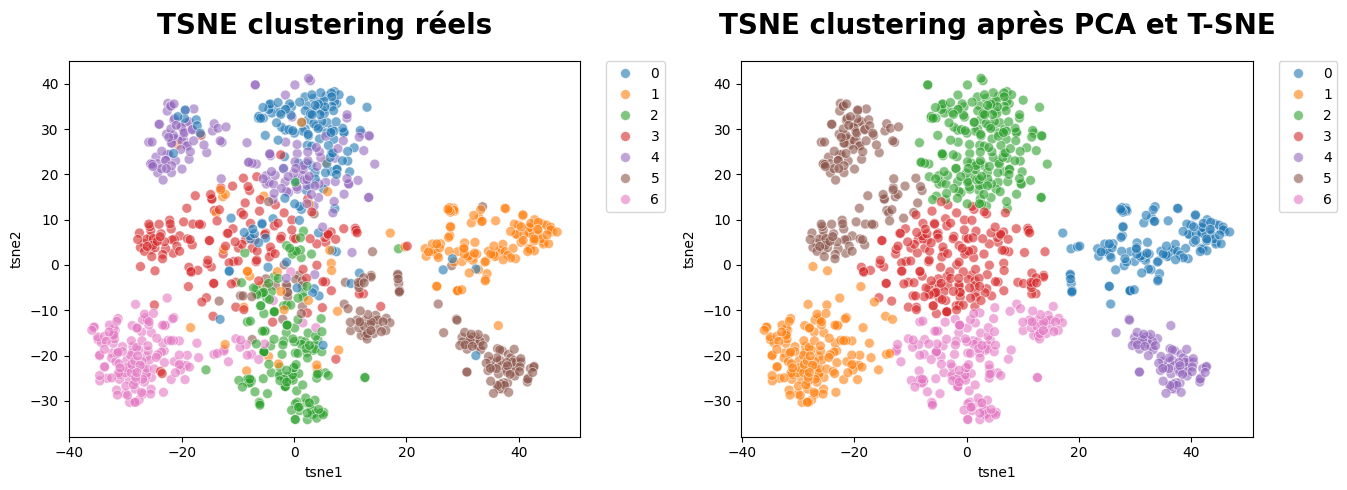

In [163]:
# Visualiser les deux clusters avec les mêmes points TSNE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Premier sous-graphique : clusters initiaux
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class_reelle",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief",
    ax=ax1
)
ax1.set_title('TSNE clustering réels', fontsize=20, pad=20, fontweight='bold')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Deuxième sous-graphique : clustering après PCA et T-SNE
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class_predite",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief",
    ax=ax2
)
ax2.set_title('TSNE clustering après PCA et T-SNE', fontsize=20, pad=20, fontweight='bold')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.tight_layout(rect=[0,0,0.85,1])
plt.show()

In [164]:
# Calcul de l'ARI entre les paires de labels
ari = adjusted_rand_score(df_tsne["class_reelle"], df_tsne["class_predite"])
print(f"Le score ARI est de :", ari)

Le score ARI est de : 0.44747615301574056


Avec la méthode CNN VGG16, le clustering est plutôt équilibré comme le clustering initial et le score ARI est moyen, presque la moitié des images sont correctement classées.


## Conclusion :

L'étude de faisabilité confirme qu'il est possible de réaliser une classification automatique des articles en fonction de leurs images.
